### imports

In [20]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import time
from functools import reduce
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from six.moves import cPickle as pickle
from six.moves import range
from collections import Counter

from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, Flatten
from keras.utils import np_utils
from keras.optimizers import SGD

%matplotlib inline

import tensorflow as tf

### parts 1-2: file loading and formatting

In [70]:
files = [
    'data_batch_1',
    'data_batch_2',
    'data_batch_3',
    'data_batch_4',
    'data_batch_5',
    'test_batch'
]

data = []
labels = []
start = time.time()
for file in files:
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='bytes')
        if file == 'test_batch':
            test_data_2d = d[b'data']
            test_labels_1d = d[b'labels']
        else:
            data.append(d[b'data'])
            labels.append(d[b'labels'])
end = time.time()
print('Time to load data: {:.3f}s\n'.format(end - start))
for i in range(len(data)):
    print('Train data {}:'.format(i+1), data[i].shape, len(labels[i]))

train_data_2d = reduce(lambda a,b: np.vstack((a,b)), data)
train_labels_1d = reduce(lambda a,b: a+b, labels)
print('\nMerged train data:', train_data_2d.shape, len(train_labels_1d))
print('Test data:', test_data_2d.shape, len(test_labels_1d))

Time to load data: 0.082s

Train data 1: (10000, 3072) 10000
Train data 2: (10000, 3072) 10000
Train data 3: (10000, 3072) 10000
Train data 4: (10000, 3072) 10000
Train data 5: (10000, 3072) 10000

Merged train data: (50000, 3072) 50000
Test data: (10000, 3072) 10000


### visualize a few of the images

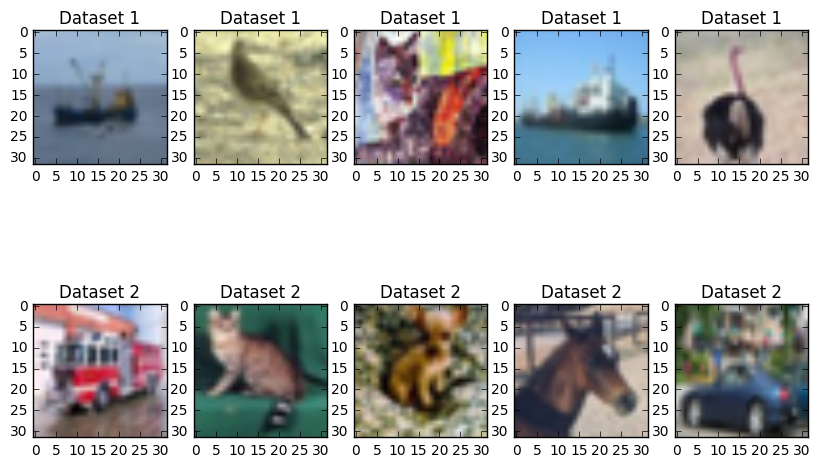

In [22]:
import matplotlib.image as mpimg

# used a batch size to speed up testing, but can easily change this to full dataset
batch_size = 1000

# random indices into the datasets so we can compare the same images across distortions
i_1 = np.random.choice(batch_size, 5)
i_2 = np.random.choice(batch_size, 5)

# basically the code from class, the images are stretched a lot but I don't think we'll
# be able to see the distortions if we view them at their actual size of 32x32 pixels
def show_images(num, i_1, dataset_1, i_2=None, dataset_2=None):
    fig1 = plt.figure(figsize=(10, 10))
    plt.gray()

    for k in range(num):
        i = i_1[k]
        if len(dataset_1.shape) == 2:
            img = np.reshape(dataset_1[i, :], (3, 32, 32)).transpose(1,2,0)
        else:
            assert(len(dataset_1.shape) == 4)
            img = dataset_1[i, :, :, :]
        imgplot1 = fig1.add_subplot(3,5,k+1)
        imgplot1.imshow(img)    
        imgplot1.set_title("Dataset 1", fontsize=12)
    
    if dataset_2 is not None:
        for k in range(num):
            i = i_2[k]
            if len(dataset_2.shape) == 2:
                img = np.reshape(dataset_2[i, :], (3, 32, 32)).transpose(1,2,0)
            else:
                assert(len(dataset_2.shape) == 4)
                img = dataset_2[i, :, :, :]
            imgplot2 = fig1.add_subplot(3,5,k+6)
            imgplot2.imshow(img)    
            imgplot2.set_title("Dataset 2", fontsize=12)
    
    plt.show()

show_images(5, i_1, train_data_2d, i_2, test_data_2d)

### dataset preprocessing

In [71]:
img_size = 32
num_labels = 10
num_channels = 3

orig_test = test_data_2d
orig_train = train_data_2d

train_labels_1d = np.array(train_labels_1d)
test_labels_1d = np.array(test_labels_1d)

# chose to go with this standardization method because it preserves the image colors, but can change it
#train_data_2d = train_data_2d / 255.0
#test_data_2d = test_data_2d / 255.0

#Trying with this method since the other one was resulting in poor accuracy
scaler = StandardScaler().fit(train_data_2d)
train_data_2d = scaler.transform(train_data_2d)
test_data_2d = scaler.transform(test_data_2d)

train_data_2d = train_data_2d.astype(np.float32)
test_data_2d = test_data_2d.astype(np.float32)

train_labels_2d = (np.arange(num_labels) == train_labels_1d[:,None]).astype(np.float32)
test_labels_2d = (np.arange(num_labels) == test_labels_1d[:,None]).astype(np.float32)

/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


### part 3c: logistic regression

In [24]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def peek_predictions(predictions, labels):
    print('Predict[:25]:', np.argmax(predictions, 1)[:25])
    print(' Actual[:25]:', np.argmax(labels, 1)[:25])

In [25]:
def lrsgd(num_epochs, train_dataset, train_labels, test_dataset, test_labels):
    batch_size = 256

    graph = tf.Graph()
    with graph.as_default():

        # Input data, with a placeholder to feed the training data at run time.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, img_size*img_size*num_channels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        weights = tf.Variable(tf.truncated_normal([img_size*img_size*num_channels, num_labels]))
        biases = tf.Variable(tf.zeros([num_labels]))

        # Training computation.
        logits = tf.matmul(tf_train_dataset, weights) + biases
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
        
    l_array = []

    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        merged = tf.merge_all_summaries()  
        writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        print("Initialized")
        for epoch in range(num_epochs):

            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)

            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]

            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            l_array.append(l)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch %d: %f" % (epoch, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        # take a peek at the model's predictions
        peek_predictions(test_prediction.eval(), test_labels)
#         test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=['LR_SGD'])

    return l_array

Initialized
Minibatch loss at epoch 0: 83.039139
Minibatch accuracy: 5.1%
Minibatch loss at epoch 500: 21.896439
Minibatch accuracy: 36.7%
Minibatch loss at epoch 1000: 38.348541
Minibatch accuracy: 24.6%

Test accuracy: 27.7%
Predict[:25]: [3 8 8 0 4 3 3 3 5 1 0 1 3 3 1 8 0 0 8 3 4 0 3 9 7]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]

Time to run: 6.027s


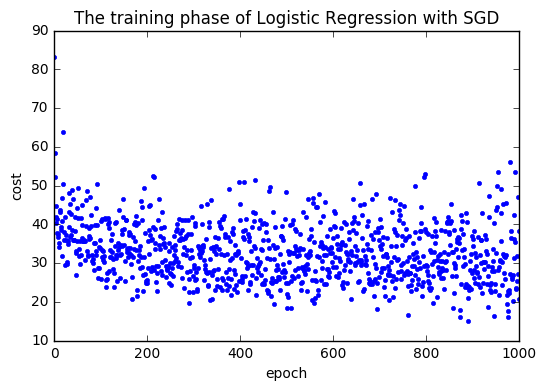

In [26]:
num_epochs = 1001
start = time.time()
l_array = lrsgd(num_epochs, train_data_2d, train_labels_2d, test_data_2d, test_labels_2d)
end = time.time()
print('\nTime to run: {:.3f}s'.format(end - start))
plt.plot(range(num_epochs), l_array, '.')
plt.xlabel("epoch")
plt.ylabel("cost")
plt.title("The training phase of Logistic Regression with SGD")
plt.show()

### part 3a: generic deep NN

In [27]:
def weight_variable(shape):
    #initial = tf.truncated_normal(shape, stddev=0.01)
    initial = tf.truncated_normal(shape, stddev=tf.sqrt(2.0/shape[0]))
    return tf.Variable(initial)


def bias_variable(shape):
    #initial = tf.constant(0.1, shape=shape)
    initial = tf.zeros(shape)
    return tf.Variable(initial)


split_by_half = lambda x,k : int(x/2**k)


def run_NN(num_epochs, name, train_dataset, train_labels, test_dataset, test_labels, k_prob=1.0):
    batch_size = 256
    hidden_nodes = 1024
    lamb_reg = 0.001
    
    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, img_size*img_size*num_channels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        layer1_weights = weight_variable([img_size*img_size*num_channels, hidden_nodes])
        layer1_biases = bias_variable([hidden_nodes])
        layer2_weights = weight_variable([hidden_nodes, split_by_half(hidden_nodes,1)])
        layer2_biases = bias_variable([split_by_half(hidden_nodes,1)])   
        layer3_weights = weight_variable([split_by_half(hidden_nodes,1), split_by_half(hidden_nodes,2)])
        layer3_biases = bias_variable([split_by_half(hidden_nodes,2)])    
        layer4_weights = weight_variable([split_by_half(hidden_nodes,2), num_labels])
        layer4_biases = bias_variable([num_labels])

        keep_prob = tf.placeholder("float")

        # Model with dropout
        def model(data, proba=keep_prob):
            layer1 = tf.matmul(data, layer1_weights) + layer1_biases
            hidden1 = tf.nn.dropout(tf.nn.relu(layer1), proba)  # dropout on hidden layer
            layer2 = tf.matmul(hidden1, layer2_weights) + layer2_biases  # a new hidden layer
            hidden2 = tf.nn.dropout(tf.nn.relu(layer2), proba)
            layer3 = tf.matmul(hidden2, layer3_weights) + layer3_biases
            hidden3 = tf.nn.dropout(tf.nn.relu(layer3), proba)
            return tf.matmul(hidden3, layer4_weights) + layer4_biases

        # Training computation.
        logits = model(tf_train_dataset, keep_prob)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
        regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) + \
                        tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) + \
                        tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) + \
                        tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) )

        # Add the regularization term to the loss.
        #loss += lamb_reg * regularizers
        loss = tf.reduce_mean(loss + lamb_reg * regularizers)

        # Optimizer.
        # learning rate decay
        global_step = tf.Variable(0)  # count number of steps taken.
        start_learning_rate = 0.05
        learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))
        
    with tf.Session(graph=graph) as session:
        merged = tf.merge_all_summaries()  
        writer = tf.train.SummaryWriter("tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}%".format(accuracy(predictions, batch_labels)))
        print("\nTest accuracy: {:.1f}%".format(accuracy(test_prediction.eval(), test_labels)))
        peek_predictions(test_prediction.eval(), test_labels)
#         test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=['LR_SGD'])
#         test_preds[name] = test_prediction.eval().ravel()


In [28]:
start = time.time()
run_NN(1001, "Deep_NN", train_data_2d, train_labels_2d, test_data_2d, test_labels_2d, 0.5)
end = time.time()
print('\nTime to run: {:.3f}s'.format(end - start))

Initialized
Minibatch loss at epoch 0: 5.593501091003418
Minibatch accuracy: 10.2%
Minibatch loss at epoch 500: 3.0766308307647705
Minibatch accuracy: 34.0%
Minibatch loss at epoch 1000: 2.9677164554595947
Minibatch accuracy: 41.4%

Test accuracy: 44.0%
Predict[:25]: [3 8 8 8 4 6 3 6 5 1 8 9 1 7 9 8 5 4 8 6 9 2 0 1 2]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]

Time to run: 75.112s


### part 3b: generic CNN

In [29]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# fixed this method to reshape the data correctly and not into meaningless pixels
def reformat(dataset, labels, img_size, num_channels=1):
    dataset = dataset.reshape((-1, img_size, img_size, num_channels)).astype(np.float32)
#     dataset = dataset.reshape((-1, num_channels, img_size, img_size)).astype(np.float32).transpose(0,2,3,1)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

In [30]:
train_data_4d, train_labels_2d = reformat(train_data_2d, train_labels_1d, img_size, num_channels)
test_data_4d, test_labels_2d = reformat(test_data_2d, test_labels_1d, img_size, num_channels)
print('Training set', train_data_4d.shape, train_labels_2d.shape)
print('Test set', test_data_4d.shape, test_labels_2d.shape)

Training set (50000, 32, 32, 3) (50000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


In [31]:
def run_CNN(num_epochs, name, train_dataset, train_labels, test_dataset, test_labels, k_prob=1.0):
    batch_size = 16
    patch_size = 5
    depth1 = 32
    depth2 = 64
    num_hidden = 1024

    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, img_size, img_size, num_channels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
        layer1_biases = bias_variable([depth1])
        layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
        layer2_biases = bias_variable([depth2])
        layer3_weights = weight_variable([img_size // 4 * img_size // 4 * depth2, num_hidden])
        layer3_biases = bias_variable([num_hidden])
        layer4_weights = weight_variable([num_hidden, num_labels])
        layer4_biases = bias_variable([num_labels])

        keep_prob = tf.placeholder(tf.float32)
        # Model with dropout
        def model(data, proba=keep_prob):
            # Convolution
            conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
            pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')
            # Convolution
            conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
            pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')
            # Fully Connected Layer
            shape = pooled2.get_shape().as_list()
            reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
            full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
            # Dropout
            full3 = tf.nn.dropout(full3, proba)
            return tf.matmul(full3, layer4_weights) + layer4_biases

        # Training computation.
        logits = model(tf_train_dataset, keep_prob)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

        # Optimizer.
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))
    
    with tf.Session(graph=graph) as session:
        merged = tf.merge_all_summaries()  
        writer = tf.train.SummaryWriter("tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}%".format(accuracy(predictions, batch_labels)))
        print("\nTest accuracy: {:.1f}%".format(accuracy(test_prediction.eval(), test_labels)))
        peek_predictions(test_prediction.eval(), test_labels)
#         test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=['LR_SGD'])
#         test_preds[name] = test_prediction.eval().ravel()


In [32]:
start = time.time()
run_CNN(1001, "CNN", train_data_4d, train_labels_2d, test_data_4d, test_labels_2d, 0.5)
end = time.time()
print('\nTime to run: {:.3f}s'.format(end - start))

Initialized
Minibatch loss at epoch 0: 2.3138341903686523
Minibatch accuracy: 12.5%
Minibatch loss at epoch 500: 1.9791380167007446
Minibatch accuracy: 12.5%
Minibatch loss at epoch 1000: 1.957000970840454
Minibatch accuracy: 25.0%

Test accuracy: 36.8%
Predict[:25]: [5 8 8 8 5 3 3 2 3 1 0 9 1 1 1 8 5 3 8 5 7 0 0 1 7]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]

Time to run: 62.389s


### part 4: subdividing training dataset

Now we're going to try varying the size of the training set.

In [34]:
c = Counter(train_labels_1d)
for i in range(num_labels):
    print(i, c[i])
#We have 5,000 of each lable in our data

bucket = []
indices = []
for i in range(0,10):
    temp = [z for z, x in enumerate(train_labels_1d) if x == i]
    indices.append(temp)
    bucket.append(indices[i])
#This finds all the indexes for each value in our training data, and stores them into the 'bucket' list of lists

0 5000
1 5000
2 5000
3 5000
4 5000
5 5000
6 5000
7 5000
8 5000
9 5000


In [35]:
t1 = []
l1 = []

t2 = []
l2 = []

t3 = []
l3 = []
#Create our training and label subsets

c12 = []
c13 = []
c23 = []
#Create our combined training sets

v12 = []
v13 = []
v23 = []
#Create our combined label sets

for i in range(0,10):
    t1.extend(bucket[i][:1700])
    l1.extend(bucket[i][:1700])
    
    t2.extend(bucket[i][1701:3400])
    l2.extend(bucket[i][1701:3400])
    
    t3.extend(bucket[i][3401:5000])
    l3.extend(bucket[i][3401:5000])
    #Now we append those index subsets together. This is for our basic sets.
    
    c12.extend(bucket[i][:3400])
    c13.extend(bucket[i][:1700])
    c13.extend(bucket[i][3401:5000])
    c23.extend(bucket[i][1701:5000])
    
    v12.extend(bucket[i][:3400])
    v13.extend(bucket[i][:1700])
    v13.extend(bucket[i][3401:5000])
    v23.extend(bucket[i][1701:5000])
    #Now for the combined sets

t1 = train_data_2d[np.array(t1)]
l1 = np.array([train_labels_1d[i] for i in l1])
l1 = (np.arange(num_labels) == l1[:,None]).astype(np.float32)

t2 = train_data_2d[np.array(t2)]
l2 = np.array([train_labels_1d[i] for i in l2])
l2 = (np.arange(num_labels) == l2[:,None]).astype(np.float32)

t3 = train_data_2d[np.array(t3)]
l3 = np.array([train_labels_1d[i] for i in l3])
l3 = (np.arange(num_labels) == l3[:,None]).astype(np.float32)
#And now we convert them so they're actually lists of values rather than indices
#Above is simple sets

c12 = train_data_2d[np.array(c12)]
v12 = np.array([train_labels_1d[i] for i in v12])
v12 = (np.arange(num_labels) == v12[:,None]).astype(np.float32)

c13 = train_data_2d[np.array(c13)]
v13 = np.array([train_labels_1d[i] for i in v13])
v13 = (np.arange(num_labels) == v13[:,None]).astype(np.float32)

c23 = train_data_2d[np.array(c23)]
v23 = np.array([train_labels_1d[i] for i in v23])
v23 = (np.arange(num_labels) == v23[:,None]).astype(np.float32)

Now we've split our data into the following sets:

T1/T2/T3: Training data, in thirds, of the original set- each containing the same number of each class
C12/C13/C23: Combined versions of the above three sets. We've already used ALL the data in a run, so there's no point to C123

In [36]:
num_epochs = 1001
start = time.time()
l_array = lrsgd(num_epochs, t1, l1, test_data_2d, test_labels_2d)
end = time.time()
print('\nTime to run: {:.3f}s'.format(end - start))

Initialized
Minibatch loss at epoch 0: 65.135834
Minibatch accuracy: 8.6%
Minibatch loss at epoch 500: 61.288418
Minibatch accuracy: 74.2%
Minibatch loss at epoch 1000: 37.974880
Minibatch accuracy: 61.7%

Test accuracy: 17.9%
Predict[:25]: [3 1 1 2 8 9 9 2 2 1 1 1 9 9 1 8 0 8 1 9 0 2 9 1 2]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]

Time to run: 5.870s


In [37]:
num_epochs = 1001
start = time.time()
l_array = lrsgd(num_epochs, c12, v12, test_data_2d, test_labels_2d)
end = time.time()
print('\nTime to run: {:.3f}s'.format(end - start))

Initialized
Minibatch loss at epoch 0: 50.302174
Minibatch accuracy: 12.1%
Minibatch loss at epoch 500: 15.171247
Minibatch accuracy: 68.0%
Minibatch loss at epoch 1000: 26.836420
Minibatch accuracy: 63.7%

Test accuracy: 16.6%
Predict[:25]: [3 2 3 7 4 3 3 3 5 1 1 1 3 3 4 4 5 6 3 4 4 5 3 0 5]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]

Time to run: 5.899s


Above is our results for the logistic regression- train time on the smaller sets is incredibly fast, but accuracy is not much better than random

In [38]:
start = time.time()
run_NN(1001, "Deep_NN", t1, l1, test_data_2d, test_labels_2d, 0.5)
end = time.time()
print('\nTime to run: {:.3f}s'.format(end - start))

Initialized
Minibatch loss at epoch 0: 2.4252588748931885
Minibatch accuracy: 61.3%
Minibatch loss at epoch 500: 2.490377426147461
Minibatch accuracy: 0.0%
Minibatch loss at epoch 1000: 2.0613040924072266
Minibatch accuracy: 44.9%

Test accuracy: 10.0%
Predict[:25]: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]

Time to run: 72.236s


In [39]:
start = time.time()
run_NN(1001, "Deep_NN", c12, v12, test_data_2d, test_labels_2d, 0.5)
end = time.time()
print('\nTime to run: {:.3f}s'.format(end - start))

Initialized
Minibatch loss at epoch 0: 2.4510750770568848
Minibatch accuracy: 13.7%
Minibatch loss at epoch 500: 0.36083322763442993
Minibatch accuracy: 100.0%
Minibatch loss at epoch 1000: 0.23775121569633484
Minibatch accuracy: 100.0%

Test accuracy: 10.0%
Predict[:25]: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]

Time to run: 71.943s


The Generic Deepnet is randomly selecting a single value, then only guessing it.

Might be that with less data, our weights are vanishing. This may be worth exploring in part 7.

In [56]:
t1, _ = reformat(t1, train_labels_1d, img_size, num_channels)
c12, _ = reformat(c12, test_labels_1d, img_size, num_channels)
print(t1.shape, l1.shape)
print(c12.shape, v12.shape)

(17000, 32, 32, 3) (17000, 10)
(34000, 32, 32, 3) (34000, 10)


In [57]:
start = time.time()
run_CNN(1001, "CNN", t1, l1, test_data_4d, test_labels_2d, 0.5)
end = time.time()
print('\nTime to run: {:.3f}s'.format(end - start))

Initialized
Minibatch loss at epoch 0: 2.3524272441864014
Minibatch accuracy: 0.0%
Minibatch loss at epoch 500: 1.3086220026016235
Minibatch accuracy: 0.0%
Minibatch loss at epoch 1000: 2.37984037399292
Minibatch accuracy: 0.0%

Test accuracy: 10.0%
Predict[:25]: [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]

Time to run: 59.912s


In [58]:
start = time.time()
run_CNN(1001, "CNN", c12, v12, test_data_4d, test_labels_2d, 0.5)
end = time.time()
print('\nTime to run: {:.3f}s'.format(end - start))

Initialized
Minibatch loss at epoch 0: 2.249910831451416
Minibatch accuracy: 56.2%
Minibatch loss at epoch 500: 0.002569508505985141
Minibatch accuracy: 100.0%
Minibatch loss at epoch 1000: 0.001899704453535378
Minibatch accuracy: 100.0%

Test accuracy: 10.0%
Predict[:25]: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]

Time to run: 54.791s


This same problem exists with the CNN. We'll have to adjust parameters.

### part 5: applying distortions to test dataset

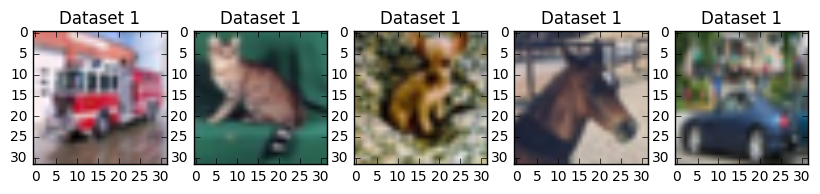

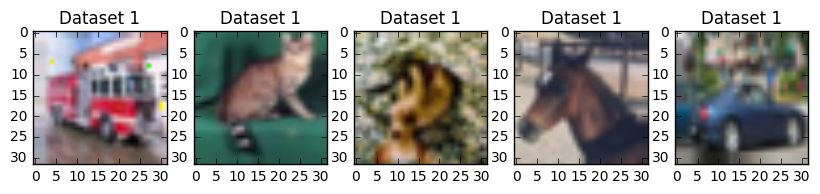

Time to run: 0.187s


In [74]:
from keras.preprocessing.image import ImageDataGenerator

# at some point when it's not 3am here I'll move this code down to after the reformatting
# but I couldn't get it to work earlier
temp_data = 255-orig_test.reshape(-1,3,32,32).transpose(0,2,3,1)
temp_labels = np_utils.to_categorical(test_labels_1d, 10)

# all the subtracting from 255 is because the image processing tool seems to invert the
# colors even if we apply no distortions
show_images(5, i_2, 255-temp_data)

start = time.time()
# there are many options for the distortions we can do with this image processing tool
datagen = ImageDataGenerator(
    width_shift_range=.1,   # randomly shifts some images 10% horizontally
    height_shift_range=.1,  # randomly shifts some images 10% vertically
    horizontal_flip=True,   # randomly flips some images horizontally
    vertical_flip=True      # randomly flips some images vertically
)
# datagen.fit(temp_data, seed=25)  # this only matters if we're using other specific parameters
for distorted_test_data, distorted_test_labels in datagen.flow(temp_data, temp_labels,
                                                            shuffle=False,
                                                            batch_size=batch_size,
                                                            seed=25):
    break  # it's an infinite generator and we just want 1 application of the distortions
end=time.time()

show_images(5, i_2, distorted_test_data)
print('Time to run: {:.3f}s'.format(end - start))

In [77]:
#Apply our scaler to our temp data
temp_data_2d = scaler.transform(orig_test)
temp_data_2d = temp_data_2d.astype(np.float32)

/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [84]:
temp_data_4d, temp_labels_2d = reformat(temp_data_2d, test_labels_1d, img_size, num_channels)
#Prepare data for CNN

In [81]:
start = time.time()
run_NN(1001, "Deep_NN", train_data_2d, train_labels_2d, temp_data_2d, test_labels_2d, 0.5)
end = time.time()
print('\nTime to run: {:.3f}s'.format(end - start))

Initialized
Minibatch loss at epoch 0: 2.46032452583313
Minibatch accuracy: 12.5%
Minibatch loss at epoch 500: 2.048487663269043
Minibatch accuracy: 28.5%
Minibatch loss at epoch 1000: 1.8757942914962769
Minibatch accuracy: 33.6%

Test accuracy: 39.7%
Predict[:25]: [5 8 8 8 6 6 5 4 5 1 8 1 1 1 9 8 3 7 8 6 7 2 0 1 2]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]

Time to run: 74.898s


Surprisingly stable all things considered. Nearly 40% is pretty good, it's fairly close to the original value sans distortion.

In [85]:
start = time.time()
run_CNN(1001, "CNN", train_data_4d, train_labels_2d, temp_data_4d, temp_labels_2d, 0.5)
end = time.time()
print('\nTime to run: {:.3f}s'.format(end - start))

Initialized
Minibatch loss at epoch 0: 2.324925422668457
Minibatch accuracy: 0.0%
Minibatch loss at epoch 500: 1.9262911081314087
Minibatch accuracy: 6.2%
Minibatch loss at epoch 1000: 2.1106488704681396
Minibatch accuracy: 18.8%

Test accuracy: 36.9%
Predict[:25]: [3 8 8 8 2 3 3 2 5 1 0 9 1 1 1 8 5 3 8 6 7 0 0 1 7]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]

Time to run: 61.279s


The CNN also seems fairly resilient, all things considered. In fact, hilariously enough, this one OUTPERFORMED the previous version!

# -----------------------------------------------------------------------------------------

Notes for stuff to try in parts 7-8:

1. sharpen images before learning
2. after running a model, try selecting a few of the images that that model got correct and compare them to a few that the model got wrong, maybe it'll clarify what the model needs to improve or what we can do to transform the data into something the model does really well with (like are all the correct ones higher contrast than the incorrect ones, or more centered, or more distinct regions to the image, etc.)
3. augment training dataset before learning? eh, we already have 50k samples, may not be worth it
4. compare different normalizations - range 0-1 or centered on 0? featurewise and samplewise?
5. Experiment with epoch size

# -------------------------------------Keras below----------------------------------------

## Keras code for CNN:

In [ ]:
subset_size = 10000

# Using the Keras way to translate the labels to one-hot format rather than the section's reformatting method
# Y_train = np_utils.to_categorical(merged_labels, num_labels)
Y_train = train_labels

X_train_subset = train_dataset[:subset_size,:,:,:]
Y_train_subset = Y_train[:subset_size,:]
print('Training subset', X_train_subset.shape, Y_train_subset.shape, '\n')

start = time.time()
# initialize model and add layers
model = Sequential()
model.add(Convolution2D(3, 3, 3, activation="relu", subsample=(2,2),\
                        input_shape=train_dataset_subset.shape[1:], name='name'))
model.add(Flatten())  # need to flatten to get correct input dimensions (2-d) for dense layer
model.add(Dense(num_labels))

sgd = SGD(lr=0.01, decay=5e-7, momentum=0.5, nesterov=True)
model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=X_train_subset, y=Y_train_subset, nb_epoch=250, batch_size=256, verbose=0)
predictions = model.predict_classes(test_dataset, batch_size=256)
end = time.time()
correct = (predictions[:,None] == test_labels_np[:,None]).astype(int)
print('\n\nTest set accuracy: {:.2f}%'.format((100.*sum(correct)/len(correct))[0]))
print('Time to run: {:.3f}s'.format(end - start))